<a href="https://colab.research.google.com/github/dcpatton/TimeSeries/blob/master/madrid_wx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exploration of time series prediction on https://www.kaggle.com/juliansimon/weather_madrid_lemd_1997_2015.csv

For a more advanced approach to forecasting weather with DNNs see
[MetNet](https://ai.googleblog.com/2020/03/a-neural-weather-model-for-eight-hour.html).



In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import random
seed = 52
tf.random.set_seed(seed)
random.seed(seed)

window_size = 2*365+1
batch_size = 32

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Retrieve and Load the Data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
#!pip install kaggle -U

In [4]:
# !kaggle datasets list -s Madrid
!kaggle datasets download -d juliansimon/weather_madrid_lemd_1997_2015.csv --unzip

  0% 0.00/145k [00:00<?, ?B/s]
100% 145k/145k [00:00<00:00, 56.6MB/s]


In [5]:
df = pd.read_csv('/content/weather_madrid_LEMD_1997_2015.csv', parse_dates={'Date':[0]})
df.shape

(6812, 23)

In [6]:
df.head()

,Date,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,1997-01-01,7.0,4.0,2.0,5.0,3.0,2.0,100.0,95.0,76.0,1010,1008,1004,10.0,9.0,4.0,13,6,NaN,0.0,6.0,NaN,229
1,1997-01-02,7.0,3.0,0.0,6.0,3.0,0.0,100.0,92.0,71.0,1007,1003,997,10.0,9.0,4.0,26,8,47.0,0.0,5.0,Rain,143
2,1997-01-03,5.0,3.0,2.0,5.0,1.0,-1.0,100.0,85.0,70.0,1005,999,996,10.0,10.0,7.0,27,19,NaN,0.0,6.0,Rain-Snow,256
3,1997-01-04,7.0,3.0,-1.0,-2.0,-3.0,-4.0,86.0,63.0,49.0,1012,1010,1005,10.0,10.0,10.0,27,19,40.0,0.0,2.0,NaN,284
4,1997-01-05,2.0,0.0,-1.0,2.0,0.0,-3.0,100.0,95.0,86.0,1012,1008,1005,10.0,5.0,1.0,14,6,NaN,0.0,7.0,Snow,2


In [7]:
start_date = df.head(1)['Date'][0]
end_date = df.tail(1)['Date'][len(df)-1]
missing_dates = pd.date_range(start=start_date, end=end_date).difference(df['Date'])
len(missing_dates)

127

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Max TemperatureC,6810.0,21.039648,8.867187,0.0,13.0,20.0,29.00,41.0
Mean TemperatureC,6809.0,14.658687,7.580461,-3.0,8.0,14.0,21.00,32.0
Min TemperatureC,6810.0,8.640529,6.837626,-10.0,3.0,9.0,14.00,28.0
Dew PointC,6810.0,8.120705,4.741067,-12.0,5.0,8.0,12.00,20.0
MeanDew PointC,6810.0,4.976211,4.654270,-15.0,2.0,6.0,8.00,16.0
Min DewpointC,6810.0,1.451248,4.909705,-22.0,-2.0,2.0,5.00,14.0
Max Humidity,6810.0,81.139354,17.531839,16.0,68.0,87.0,94.00,100.0
Mean Humidity,6810.0,57.971366,19.675744,15.0,41.0,59.0,74.00,100.0
Min Humidity,6810.0,34.729369,19.320359,4.0,19.0,32.0,47.75,100.0
Max Sea Level PressurehPa,6812.0,1020.529360,6.235941,994.0,1017.0,1020.0,1024.00,1047.0


In [9]:
missing_MeanTemp = df.loc[df['Mean TemperatureC'].isna()]
missing_MeanTemp

,Date,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
1240,2000-08-22,27.0,NaN,27.0,-1.0,-1.0,-1.0,16.0,16.0,16.0,1015,1015,1015,NaN,NaN,NaN,19,19,NaN,0.0,NaN,NaN,260
1539,2001-06-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1021,1019,1018,NaN,NaN,NaN,26,14,NaN,0.0,NaN,NaN,231
1540,2001-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1021,1019,1016,NaN,NaN,NaN,26,11,NaN,0.0,NaN,NaN,248


# Clean the data

Note that the counts for many columns are not at 6812.

In [10]:
last_missing_datetime = missing_dates[-1:].values[0]
last_missing_datetime

numpy.datetime64('2004-01-31T00:00:00.000000000')

In [11]:
original_df = df.copy(deep=True)

I will only use continuous data (no missing days). This also removes the three dates with missing temperatures since they were in 2000 and 2001.

In [12]:
df = df[df['Date'] > '2004-01-31'].reset_index(drop=True)

In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Max TemperatureC,4352.0,21.250689,8.982573,0.0,14.00,21.0,29.0,41.0
Mean TemperatureC,4352.0,14.790441,7.707400,-3.0,8.00,14.0,22.0,31.0
Min TemperatureC,4352.0,8.641544,6.960585,-10.0,3.00,9.0,14.0,26.0
Dew PointC,4352.0,7.861903,4.824524,-12.0,5.00,8.0,11.0,20.0
MeanDew PointC,4352.0,4.671415,4.730477,-15.0,2.00,5.0,8.0,16.0
Min DewpointC,4352.0,1.053079,4.964288,-22.0,-2.00,1.0,4.0,14.0
Max Humidity,4352.0,80.089844,17.970109,26.0,66.00,86.0,94.0,100.0
Mean Humidity,4352.0,56.518382,19.915857,15.0,39.00,57.0,73.0,99.0
Min Humidity,4352.0,32.469899,19.211592,4.0,16.00,29.0,45.0,93.0
Max Sea Level PressurehPa,4352.0,1020.367417,6.364322,994.0,1017.00,1020.0,1024.0,1047.0


# Preprocess data

We are going to use the last 3 years as test data.

In [14]:
split_index = df[df['Date'] == '2013-01-01'].index[0]

In [15]:
# drop features we are not considering
df.drop(['Date', 'Max TemperatureC', 'Min TemperatureC',
       'Dew PointC', 'MeanDew PointC', 'Min DewpointC', 'Max Humidity',
       ' Mean Humidity', ' Min Humidity', ' Max Sea Level PressurehPa',
       ' Mean Sea Level PressurehPa', ' Min Sea Level PressurehPa',
       ' Max VisibilityKm', ' Mean VisibilityKm', ' Min VisibilitykM',
       ' Max Wind SpeedKm/h', ' Mean Wind SpeedKm/h', ' Max Gust SpeedKm/h',
       'Precipitationmm', ' CloudCover', ' Events', 'WindDirDegrees'], axis='columns', inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4352 entries, 0 to 4351
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Mean TemperatureC  4352 non-null   float64
dtypes: float64(1)
memory usage: 34.1 KB


split training, validation, and test data (last 3 years)

In [17]:
from sklearn.model_selection import train_test_split

train_df = df[:split_index]
train_df, val_df = train_test_split(train_df, test_size=0.225, shuffle=False)
test_df = df[split_index:]
len(val_df)

733

In [18]:
# #Normalize
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [19]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

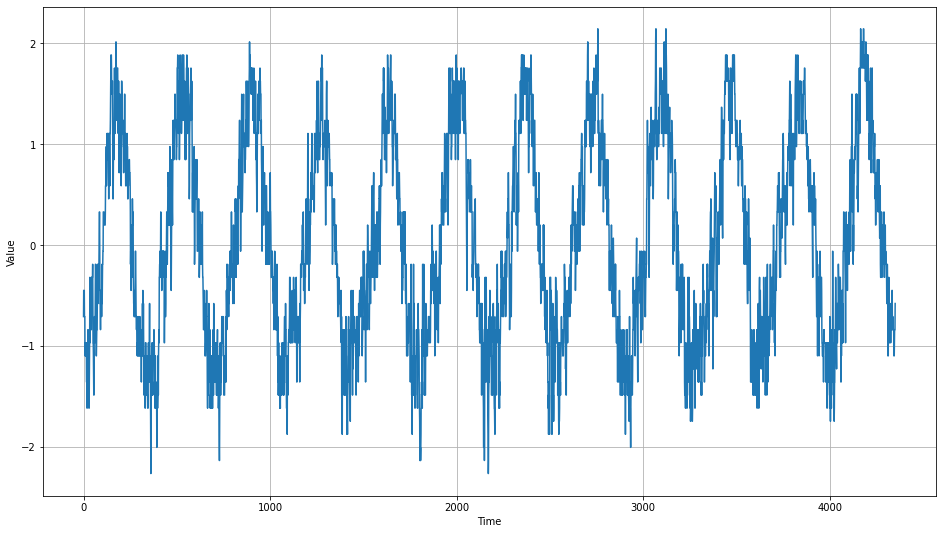

In [20]:
series_df = df
series_df = (series_df - train_mean) / train_std
series = np.array(series_df['Mean TemperatureC'])
time = np.array(df.index)
plt.figure(figsize=(16, 9))
plot_series(time, series)

In [21]:
def get_dataset(series, window_size, batch_size, shuffle=False, cache=False):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))
  ds = ds.map(lambda window: (window[:-1], window[-1]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  if shuffle:
    ds = ds.shuffle(1024)
  ds = ds.batch(batch_size)
  if cache:
    ds = ds.cache()
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

In [22]:
x_train = np.array(train_df['Mean TemperatureC'])
train_ds = get_dataset(x_train, window_size, batch_size, shuffle=True)
x_val = np.array(val_df['Mean TemperatureC'])
val_ds = get_dataset(x_val, window_size, batch_size, shuffle=False, cache=True)
x_test = np.array(test_df['Mean TemperatureC'])
test_ds = get_dataset(x_test, window_size, batch_size, shuffle=False, cache=True)

y_true = x_test

# Baseline

model that just returns the current temperature as the prediction, predicting "No change"

In [23]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense, Lambda
from tensorflow.keras import Model, Input

input1 = Input(shape=(window_size,))
out = Lambda(lambda x: x[:,-1])(input1)

model = Model(inputs=[input1], outputs=[out])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', 
              metrics=['mae'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 731)]             0         
_________________________________________________________________
lambda (Lambda)              (None,)                   0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [24]:
# model.load_weights('model.h5')
(mse, mae) = model.evaluate(test_ds)
print('mean squared error = ' + str(mse))
print('mean absolute error = ' + str(mae))

12/12 [==============================] - 0s 19ms/step - loss: 0.0739 - mae: 0.1922
mean squared error = 0.07386527210474014
mean absolute error = 0.1921520084142685


In [25]:
def unscale_series(s):
  return (s * train_std[0]) +  train_mean[0]

In [26]:
results = model.predict(test_ds)

m = tf.keras.metrics.MeanAbsoluteError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mae = m.result().numpy()

m = tf.keras.metrics.MeanSquaredError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mse = m.result().numpy()

In [27]:
report = pd.DataFrame(columns=['Model', 'MAE', 'MSE'])
report.loc[len(report)] = ['Baseline', mae, mse]

# DNN Model

In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed)
random.seed(seed)

from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras import Model, Input

input1 = Input(shape=(window_size,))
x = Dense(512, activation='swish')(input1)
x = Dropout(.5)(x)
x = Dense(256, activation='swish')(x)
x = Dropout(.5)(x)
x = Dense(128, activation='swish')(x)
x = Dropout(.5)(x)
x = Dense(64, activation='swish')(x)
x = Dropout(.5)(x)
out = Dense(1)(x)

model = Model(inputs=[input1], outputs=[out])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', 
              metrics=['mae'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 731)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               374784    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [29]:
filepath = 'model.h5'

mc = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=0, save_weights_only=True, 
                                        monitor='val_loss', mode='auto', save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

history = model.fit(train_ds, epochs=500, verbose=2, callbacks=[es, mc], validation_data=val_ds)

Epoch 1/500
57/57 - 1s - loss: 1.8689 - mae: 1.0519 - val_loss: 0.7306 - val_mae: 0.8546
Epoch 2/500
57/57 - 1s - loss: 0.7464 - mae: 0.6718 - val_loss: 0.3333 - val_mae: 0.5773
Epoch 3/500
57/57 - 1s - loss: 0.5911 - mae: 0.6079 - val_loss: 0.2867 - val_mae: 0.5354
Epoch 4/500
57/57 - 1s - loss: 0.4547 - mae: 0.5360 - val_loss: 0.2916 - val_mae: 0.5399
Epoch 5/500
57/57 - 1s - loss: 0.3648 - mae: 0.4794 - val_loss: 0.3313 - val_mae: 0.5755
Epoch 6/500
57/57 - 1s - loss: 0.3634 - mae: 0.4751 - val_loss: 0.2982 - val_mae: 0.5461
Epoch 7/500
57/57 - 1s - loss: 0.3258 - mae: 0.4523 - val_loss: 0.4014 - val_mae: 0.6336
Epoch 8/500
57/57 - 1s - loss: 0.3473 - mae: 0.4671 - val_loss: 0.3651 - val_mae: 0.6042
Epoch 9/500
57/57 - 1s - loss: 0.3663 - mae: 0.4715 - val_loss: 0.2333 - val_mae: 0.4830
Epoch 10/500
57/57 - 1s - loss: 0.3450 - mae: 0.4731 - val_loss: 0.3472 - val_mae: 0.5892
Epoch 11/500
57/57 - 1s - loss: 0.2778 - mae: 0.4190 - val_loss: 0.3190 - val_mae: 0.5648
Epoch 12/500
57/57 

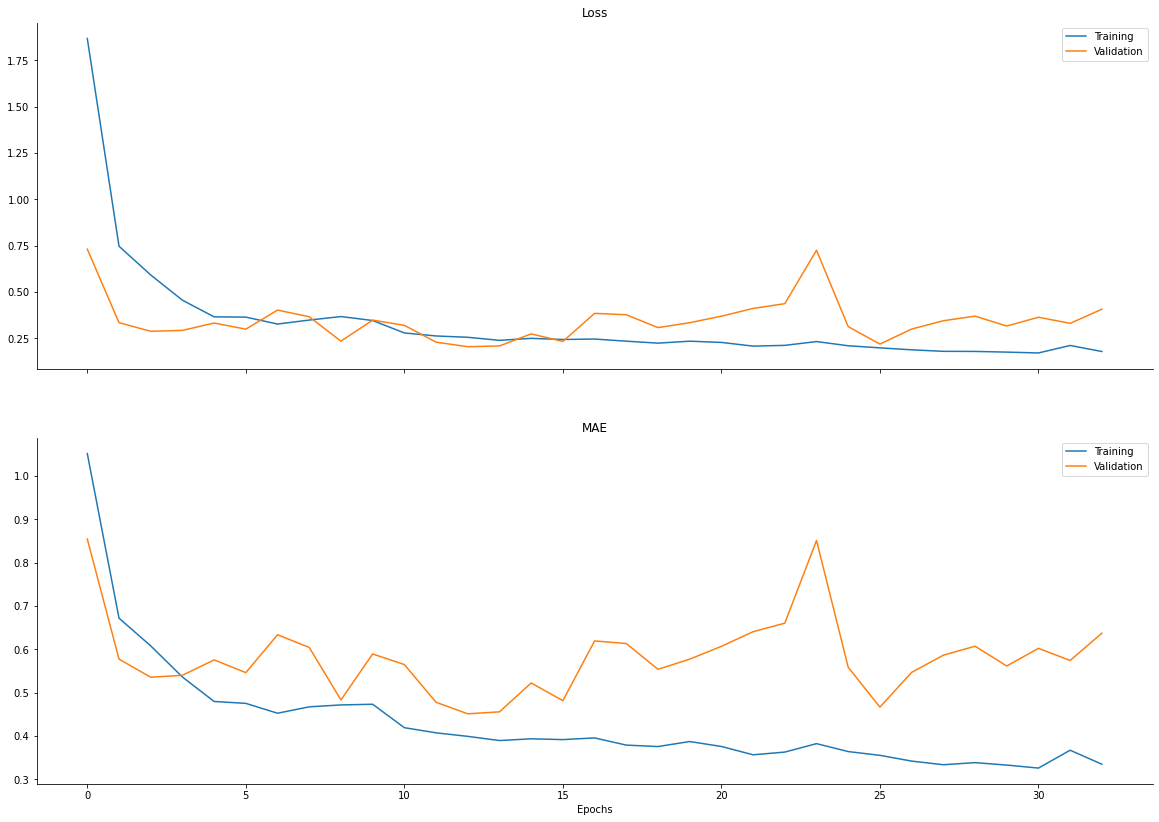

In [30]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['mae'], label='Training')
ax2.plot(history['val_mae'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('MAE')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [31]:
model.load_weights('model.h5')
(mse, mae) = model.evaluate(test_ds)
print('mean squared error = ' + str(mse))
print('mean absolute error = ' + str(mae))

12/12 [==============================] - 0s 3ms/step - loss: 0.2062 - mae: 0.3696
mean squared error = 0.20623938739299774
mean absolute error = 0.3695940375328064


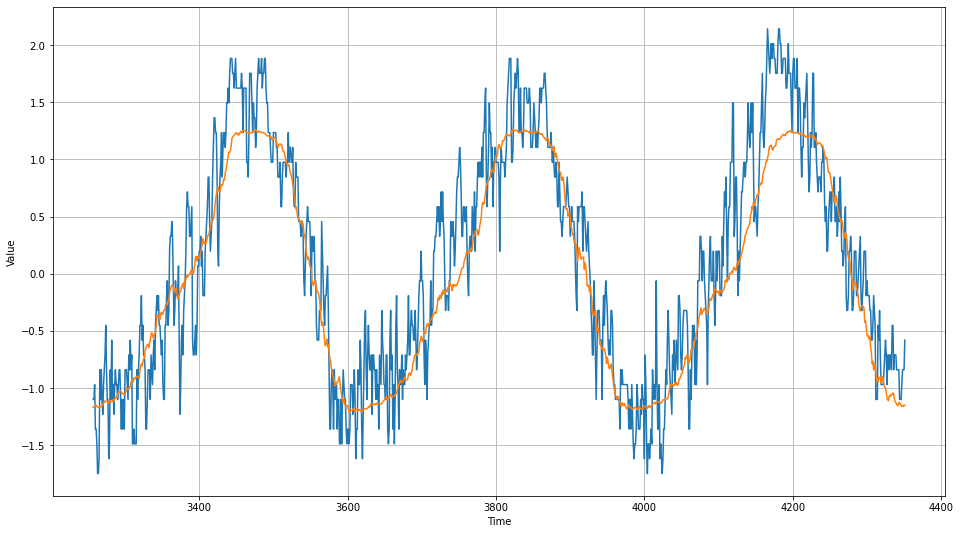

In [32]:
time_test = np.array(test_df.index)

forecast=[]
times = range(split_index-window_size, len(series)-window_size)
for time in times:
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(16, 9))

plot_series(time_test, x_test)
plot_series(time_test, results)

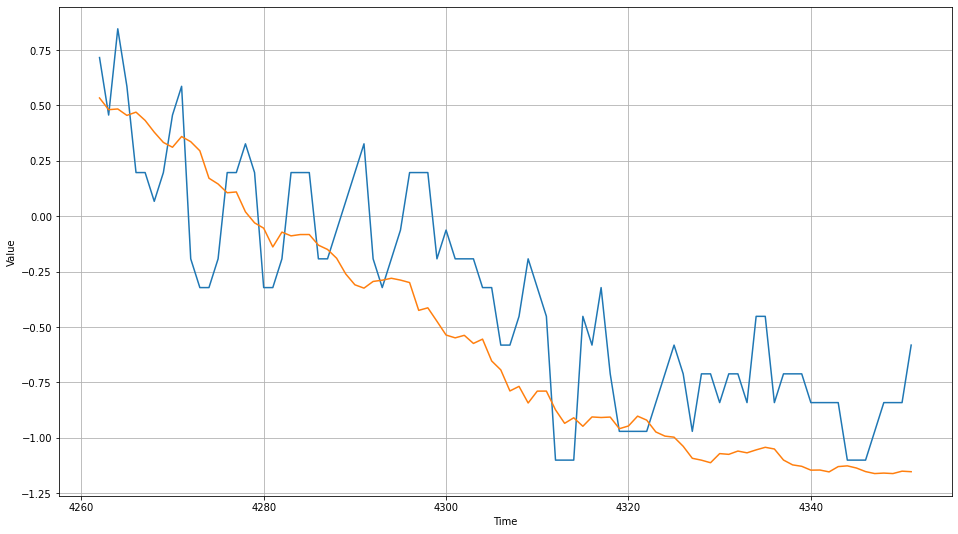

In [33]:
plt.figure(figsize=(16, 9))

plot_series(time_test[-90:], x_test[-90:])
plot_series(time_test[-90:], results[-90:])

In [34]:
results = model.predict(test_ds)

m = tf.keras.metrics.MeanAbsoluteError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mae = m.result().numpy()

m = tf.keras.metrics.MeanSquaredError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mse = m.result().numpy()

report.loc[len(report)] = ['DNN', mae, mse]

# SimpleRNN Model

In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed)
random.seed(seed)

from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras import Model

input1 = Input(shape=[window_size,1])
x = SimpleRNN(64)(input1)
x = Dense(64, activation='swish')(x)
out = Dense(1)(x)

model = Model(inputs=[input1], outputs=[out])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', 
              metrics=['mae'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 731, 1)]          0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                4224      
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 8,449
Trainable params: 8,449
Non-trainable params: 0
_________________________________________________________________


In [36]:
filepath = 'model.h5'

mc = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=0, save_weights_only=True, 
                                        monitor='val_loss', mode='auto', save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

history = model.fit(train_ds, epochs=500, verbose=2, callbacks=[es, mc], validation_data=val_ds)

Epoch 1/500
57/57 - 25s - loss: 0.1183 - mae: 0.2637 - val_loss: 0.0229 - val_mae: 0.1347
Epoch 2/500
57/57 - 25s - loss: 0.0689 - mae: 0.2058 - val_loss: 0.0324 - val_mae: 0.1765
Epoch 3/500
57/57 - 25s - loss: 0.0677 - mae: 0.2038 - val_loss: 0.0026 - val_mae: 0.0494
Epoch 4/500
57/57 - 25s - loss: 0.0670 - mae: 0.2029 - val_loss: 0.0014 - val_mae: 0.0356
Epoch 5/500
57/57 - 25s - loss: 0.0723 - mae: 0.2106 - val_loss: 0.0483 - val_mae: 0.2174
Epoch 6/500
57/57 - 25s - loss: 0.0672 - mae: 0.2031 - val_loss: 0.0052 - val_mae: 0.0630
Epoch 7/500
57/57 - 25s - loss: 0.0644 - mae: 0.1983 - val_loss: 0.0046 - val_mae: 0.0513
Epoch 8/500
57/57 - 25s - loss: 0.0639 - mae: 0.1968 - val_loss: 0.0188 - val_mae: 0.1220
Epoch 9/500
57/57 - 25s - loss: 0.0639 - mae: 0.1966 - val_loss: 0.0214 - val_mae: 0.1311
Epoch 10/500
57/57 - 25s - loss: 0.0634 - mae: 0.1965 - val_loss: 0.0069 - val_mae: 0.0631
Epoch 11/500
57/57 - 25s - loss: 0.0639 - mae: 0.1984 - val_loss: 0.0618 - val_mae: 0.2412
Epoch 12

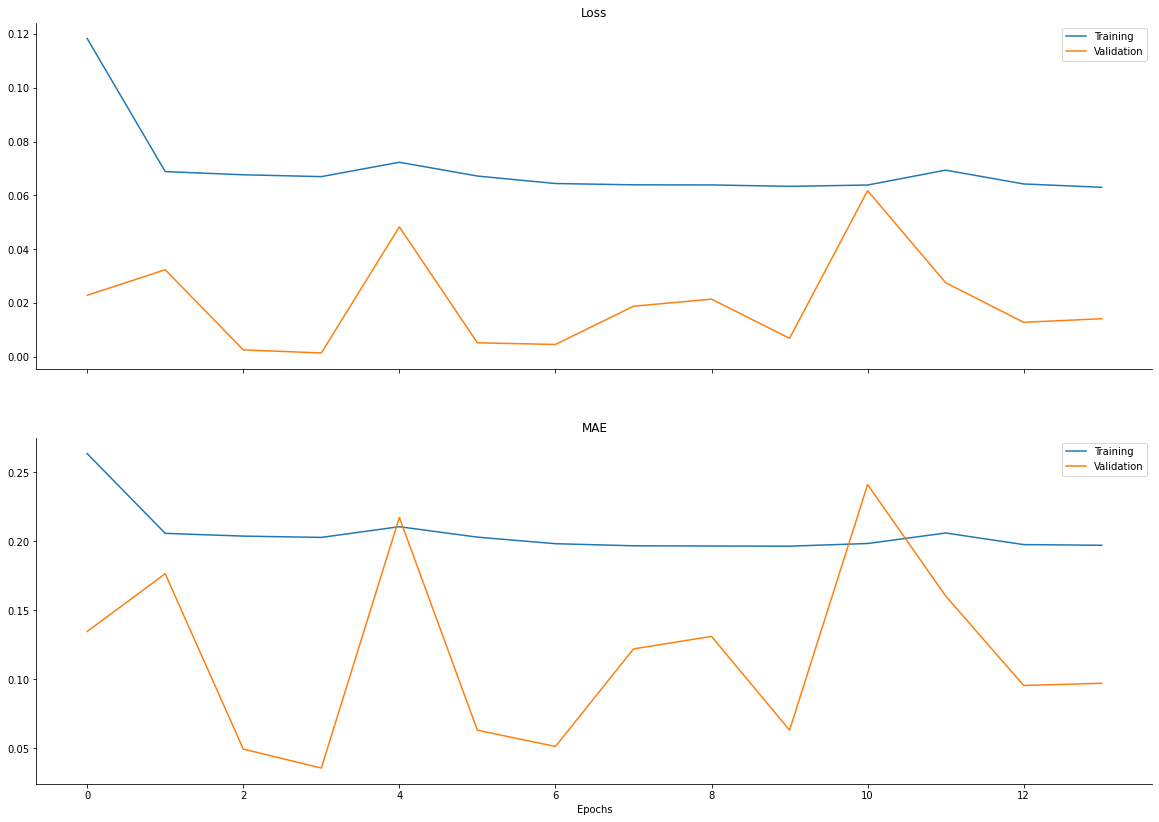

In [37]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['mae'], label='Training')
ax2.plot(history['val_mae'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('MAE')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [38]:
model.load_weights('model.h5')
(mse, mae) = model.evaluate(test_ds)
print('mean squared error = ' + str(mse))
print('mean absolute error = ' + str(mae))

results = model.predict(test_ds)

m = tf.keras.metrics.MeanAbsoluteError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mae = m.result().numpy()

m = tf.keras.metrics.MeanSquaredError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mse = m.result().numpy()

report.loc[len(report)] = ['SimpleRNN', mae, mse]

12/12 [==============================] - 1s 46ms/step - loss: 0.0712 - mae: 0.2054
mean squared error = 0.07123564928770065
mean absolute error = 0.20537970960140228


# GRU Model

In [39]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed)
random.seed(seed)

from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras import Model

input1 = Input(shape=[window_size,1])
x = GRU(64)(input1)
x = Dense(64, activation='swish')(x)
out = Dense(1)(x)

model = Model(inputs=[input1], outputs=[out])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', 
              metrics=['mae'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 731, 1)]          0         
_________________________________________________________________
gru (GRU)                    (None, 64)                12864     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 17,089
Trainable params: 17,089
Non-trainable params: 0
_________________________________________________________________


In [40]:
filepath = 'model.h5'

mc = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=0, save_weights_only=True, 
                                        monitor='val_loss', mode='auto', save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

history = model.fit(train_ds, epochs=500, verbose=2, callbacks=[es, mc], validation_data=val_ds)

Epoch 1/500
57/57 - 2s - loss: 0.2226 - mae: 0.3470 - val_loss: 0.0035 - val_mae: 0.0500
Epoch 2/500
57/57 - 1s - loss: 0.0884 - mae: 0.2362 - val_loss: 0.0567 - val_mae: 0.2356
Epoch 3/500
57/57 - 2s - loss: 0.0777 - mae: 0.2199 - val_loss: 0.0168 - val_mae: 0.1262
Epoch 4/500
57/57 - 2s - loss: 0.0738 - mae: 0.2135 - val_loss: 0.0149 - val_mae: 0.1208
Epoch 5/500
57/57 - 2s - loss: 0.0714 - mae: 0.2084 - val_loss: 7.9117e-04 - val_mae: 0.0261
Epoch 6/500
57/57 - 2s - loss: 0.0693 - mae: 0.2049 - val_loss: 0.0032 - val_mae: 0.0565
Epoch 7/500
57/57 - 1s - loss: 0.0689 - mae: 0.2037 - val_loss: 0.0105 - val_mae: 0.1023
Epoch 8/500
57/57 - 2s - loss: 0.0675 - mae: 0.2011 - val_loss: 0.0273 - val_mae: 0.1643
Epoch 9/500
57/57 - 1s - loss: 0.0672 - mae: 0.2010 - val_loss: 0.0125 - val_mae: 0.1107
Epoch 10/500
57/57 - 1s - loss: 0.0659 - mae: 0.1991 - val_loss: 0.0226 - val_mae: 0.1491
Epoch 11/500
57/57 - 1s - loss: 0.0654 - mae: 0.1995 - val_loss: 0.0041 - val_mae: 0.0619
Epoch 12/500
57

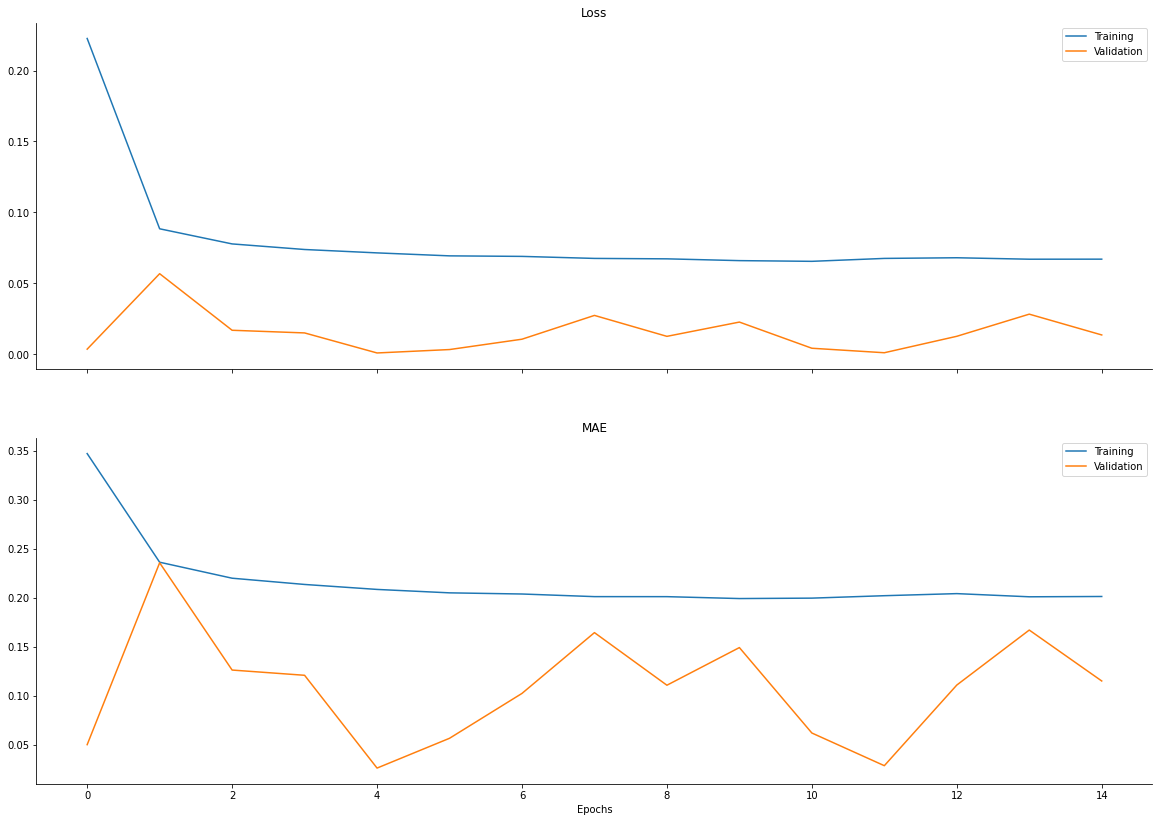

In [41]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['mae'], label='Training')
ax2.plot(history['val_mae'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('MAE')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [42]:
model.load_weights('model.h5')
(mse, mae) = model.evaluate(test_ds)
print('mean squared error = ' + str(mse))
print('mean absolute error = ' + str(mae))

results = model.predict(test_ds)

m = tf.keras.metrics.MeanAbsoluteError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mae = m.result().numpy()

m = tf.keras.metrics.MeanSquaredError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mse = m.result().numpy()

report.loc[len(report)] = ['GRU', mae, mse]

12/12 [==============================] - 0s 12ms/step - loss: 0.0741 - mae: 0.2119
mean squared error = 0.0740792378783226
mean absolute error = 0.21185162663459778


# LSTM Model

In [43]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed)
random.seed(seed)

from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import Model

input1 = Input(shape=[window_size,1])
x = LSTM(512)(input1)
x = Dense(256, activation='elu')(x)
x = Dense(128, activation='elu')(x)
out = Dense(1)(x)

model = Model(inputs=[input1], outputs=[out])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', 
              metrics=['mae'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 731, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1052672   
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,217,025
Trainable params: 1,217,025
Non-trainable params: 0
_________________________________________________________________


In [44]:
filepath = 'model.h5'

mc = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=0, save_weights_only=True, 
                                        monitor='val_loss', mode='auto', save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

history = model.fit(train_ds, epochs=500, verbose=2, callbacks=[es, mc], validation_data=val_ds)

Epoch 1/500
57/57 - 3s - loss: 0.1606 - mae: 0.2967 - val_loss: 0.0057 - val_mae: 0.0652
Epoch 2/500
57/57 - 3s - loss: 0.0767 - mae: 0.2171 - val_loss: 0.0255 - val_mae: 0.1593
Epoch 3/500
57/57 - 3s - loss: 0.0727 - mae: 0.2118 - val_loss: 0.0102 - val_mae: 0.1009
Epoch 4/500
57/57 - 3s - loss: 0.0702 - mae: 0.2060 - val_loss: 0.0378 - val_mae: 0.1945
Epoch 5/500
57/57 - 3s - loss: 0.0721 - mae: 0.2073 - val_loss: 0.0166 - val_mae: 0.1286
Epoch 6/500
57/57 - 3s - loss: 0.0669 - mae: 0.2010 - val_loss: 0.0210 - val_mae: 0.1446
Epoch 7/500
57/57 - 3s - loss: 0.0691 - mae: 0.2051 - val_loss: 0.0076 - val_mae: 0.0872
Epoch 8/500
57/57 - 3s - loss: 0.0681 - mae: 0.2025 - val_loss: 0.0081 - val_mae: 0.0888
Epoch 9/500
57/57 - 3s - loss: 0.0687 - mae: 0.2047 - val_loss: 0.0137 - val_mae: 0.1164
Epoch 10/500
57/57 - 3s - loss: 0.0681 - mae: 0.2033 - val_loss: 0.0545 - val_mae: 0.2329
Epoch 11/500
57/57 - 3s - loss: 0.0694 - mae: 0.2043 - val_loss: 0.0572 - val_mae: 0.2386
Epoch 12/500
57/57 

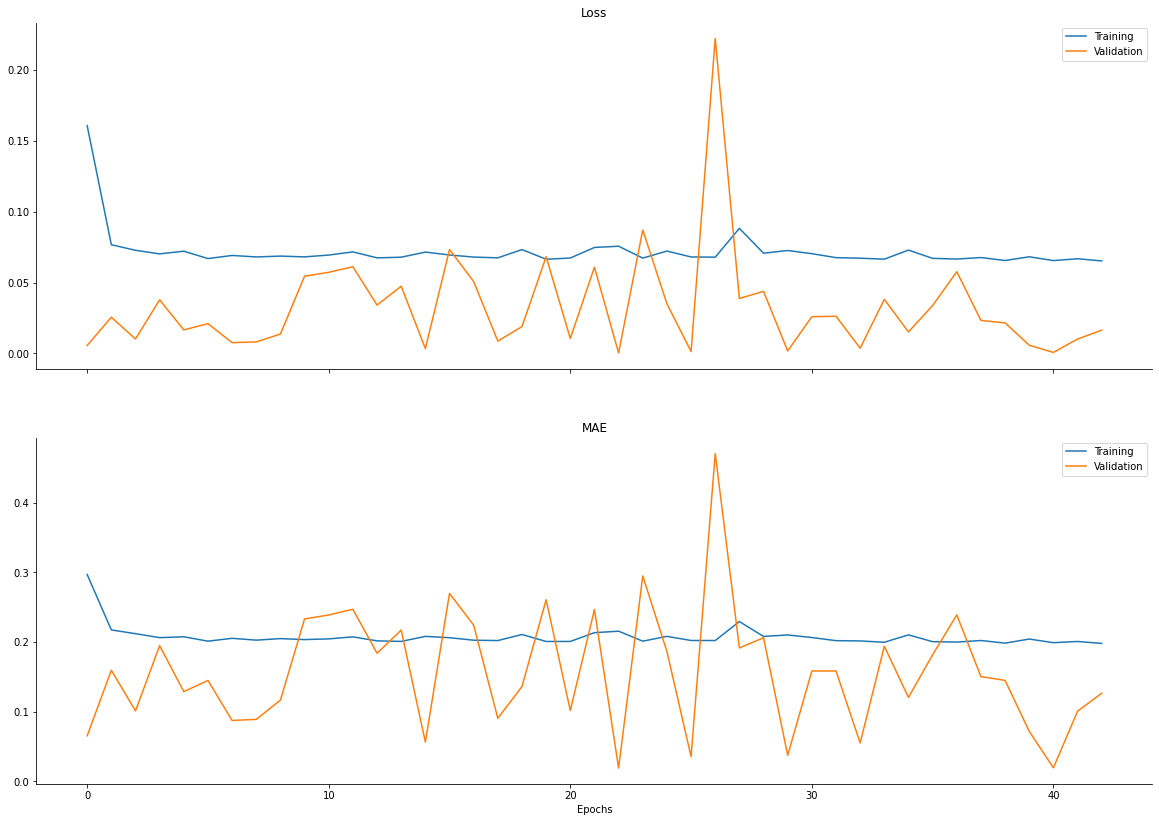

In [45]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['mae'], label='Training')
ax2.plot(history['val_mae'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('MAE')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [46]:
model.load_weights('model.h5')
(mse, mae) = model.evaluate(test_ds)
print('mean squared error = ' + str(mse))
print('mean absolute error = ' + str(mae))

12/12 [==============================] - 0s 23ms/step - loss: 0.0772 - mae: 0.2088
mean squared error = 0.07723426818847656
mean absolute error = 0.2088179588317871


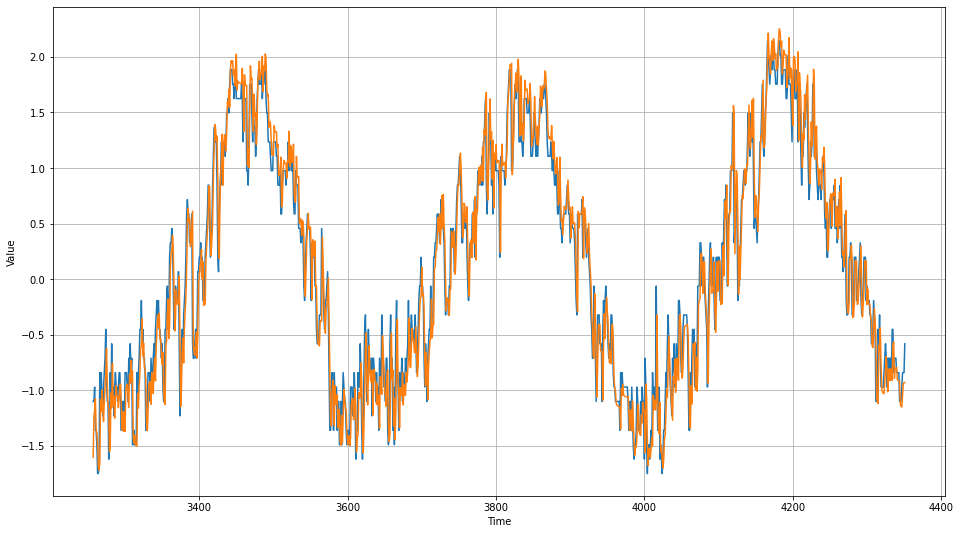

In [47]:
time_test = np.array(test_df.index)

forecast=[]
times = range(split_index-window_size, len(series)-window_size)
for time in times:
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(16, 9))

plot_series(time_test, x_test)
plot_series(time_test, results)

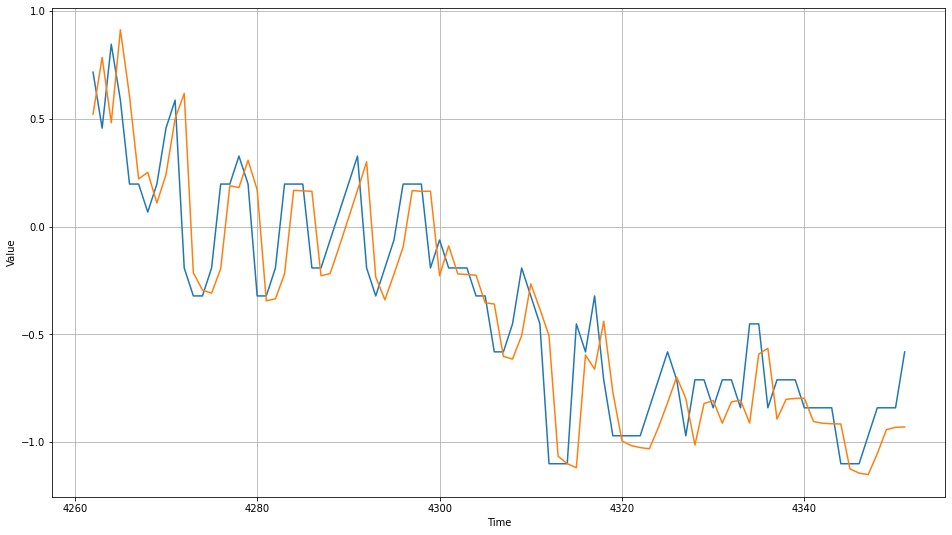

In [48]:
plt.figure(figsize=(16, 9))

plot_series(time_test[-90:], x_test[-90:])
plot_series(time_test[-90:], results[-90:])

In [49]:
results = model.predict(test_ds)

m = tf.keras.metrics.MeanAbsoluteError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mae = m.result().numpy()

m = tf.keras.metrics.MeanSquaredError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mse = m.result().numpy()

report.loc[len(report)] = ['LSTM', mae, mse]

# Additional inputs

Given events as additional input, can we improve our results?

In [50]:
df = original_df.copy(deep=True)
df = df[df['Date'] > '2004-01-31'].reset_index(drop=True)
df.drop(['Date', 'Max TemperatureC', 'Min TemperatureC',
       'Dew PointC', 'MeanDew PointC', 'Min DewpointC', 'Max Humidity',
       ' Mean Humidity', ' Min Humidity', ' Max Sea Level PressurehPa',
       ' Mean Sea Level PressurehPa', ' Min Sea Level PressurehPa',
       ' Max VisibilityKm', ' Mean VisibilityKm', ' Min VisibilitykM',
       ' Max Wind SpeedKm/h', ' Mean Wind SpeedKm/h', ' Max Gust SpeedKm/h',
       'Precipitationmm', ' CloudCover', 'WindDirDegrees'], axis='columns', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4352 entries, 0 to 4351
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Mean TemperatureC  4352 non-null   float64
 1    Events            1123 non-null   object 
dtypes: float64(1), object(1)
memory usage: 68.1+ KB


In [51]:
df[' Events'] = df[' Events'].fillna('Nada') # Nothing happened on most days

In [52]:
df = pd.get_dummies(df, prefix='event', columns=[' Events'])

In [53]:
from sklearn.model_selection import train_test_split

train_df = df[:split_index]
train_df, val_df = train_test_split(train_df, test_size=0.225, shuffle=False)
test_df = df[split_index:]

train_mean = train_df['Mean TemperatureC'].mean()
train_std = train_df['Mean TemperatureC'].std()

train_df['Mean TemperatureC'] = (train_df['Mean TemperatureC'] - train_mean) / train_std
val_df['Mean TemperatureC'] = (val_df['Mean TemperatureC'] - train_mean) / train_std
test_df['Mean TemperatureC'] = (test_df['Mean TemperatureC'] - train_mean) / train_std

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [54]:
def get_m_dataset(series, window_size, batch_size, shuffle=False, cache=False):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))
  ds = ds.map(lambda window: (window[:-1:], window[-1][:1]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  if shuffle:
    ds = ds.shuffle(1024)
  ds = ds.batch(batch_size)
  if cache:
    ds = ds.cache()
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

In [55]:
x_train = np.array(train_df, dtype=np.float32)
train_ds = get_m_dataset(x_train, window_size, batch_size, shuffle=True)
x_val = np.array(val_df, dtype=np.float32)
val_ds = get_m_dataset(x_val, window_size, batch_size, shuffle=False, cache=True)
x_test = np.array(test_df, dtype=np.float32)
test_ds = get_m_dataset(x_test, window_size, batch_size, shuffle=False, cache=True)

In [56]:
# for element in test_ds.take(1):
#   print(element)

In [57]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed)
random.seed(seed)

from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import Model, Input

input1 = Input(shape=[window_size, 14])
x = LSTM(512)(input1)
x = Dense(256, activation='swish')(x)
x = Dense(128, activation='swish')(x)
out = Dense(1)(x)

model = Model(inputs=[input1], outputs=[out])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', 
              metrics=['mae'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 731, 14)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1079296   
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,243,649
Trainable params: 1,243,649
Non-trainable params: 0
_________________________________________________________________


In [58]:
filepath = 'model.h5'

mc = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=0, save_weights_only=True, 
                                        monitor='val_loss', mode='auto', save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

history = model.fit(train_ds, epochs=500, verbose=2, callbacks=[es, mc], validation_data=val_ds)

Epoch 1/500
57/57 - 4s - loss: 0.2639 - mae: 0.3748 - val_loss: 0.0333 - val_mae: 0.1715
Epoch 2/500
57/57 - 3s - loss: 0.0962 - mae: 0.2458 - val_loss: 0.0049 - val_mae: 0.0657
Epoch 3/500
57/57 - 3s - loss: 0.0802 - mae: 0.2234 - val_loss: 0.0043 - val_mae: 0.0575
Epoch 4/500
57/57 - 3s - loss: 0.0770 - mae: 0.2197 - val_loss: 0.0018 - val_mae: 0.0399
Epoch 5/500
57/57 - 3s - loss: 0.0701 - mae: 0.2077 - val_loss: 0.0098 - val_mae: 0.0933
Epoch 6/500
57/57 - 3s - loss: 0.0683 - mae: 0.2036 - val_loss: 0.0276 - val_mae: 0.1625
Epoch 7/500
57/57 - 3s - loss: 0.0669 - mae: 0.2027 - val_loss: 0.0110 - val_mae: 0.1010
Epoch 8/500
57/57 - 3s - loss: 0.0662 - mae: 0.1999 - val_loss: 0.0052 - val_mae: 0.0684
Epoch 9/500
57/57 - 3s - loss: 0.0642 - mae: 0.1974 - val_loss: 0.0204 - val_mae: 0.1414
Epoch 10/500
57/57 - 3s - loss: 0.0648 - mae: 0.1988 - val_loss: 0.0024 - val_mae: 0.0462
Epoch 11/500
57/57 - 3s - loss: 0.0689 - mae: 0.2056 - val_loss: 0.0305 - val_mae: 0.1741
Epoch 12/500
57/57 

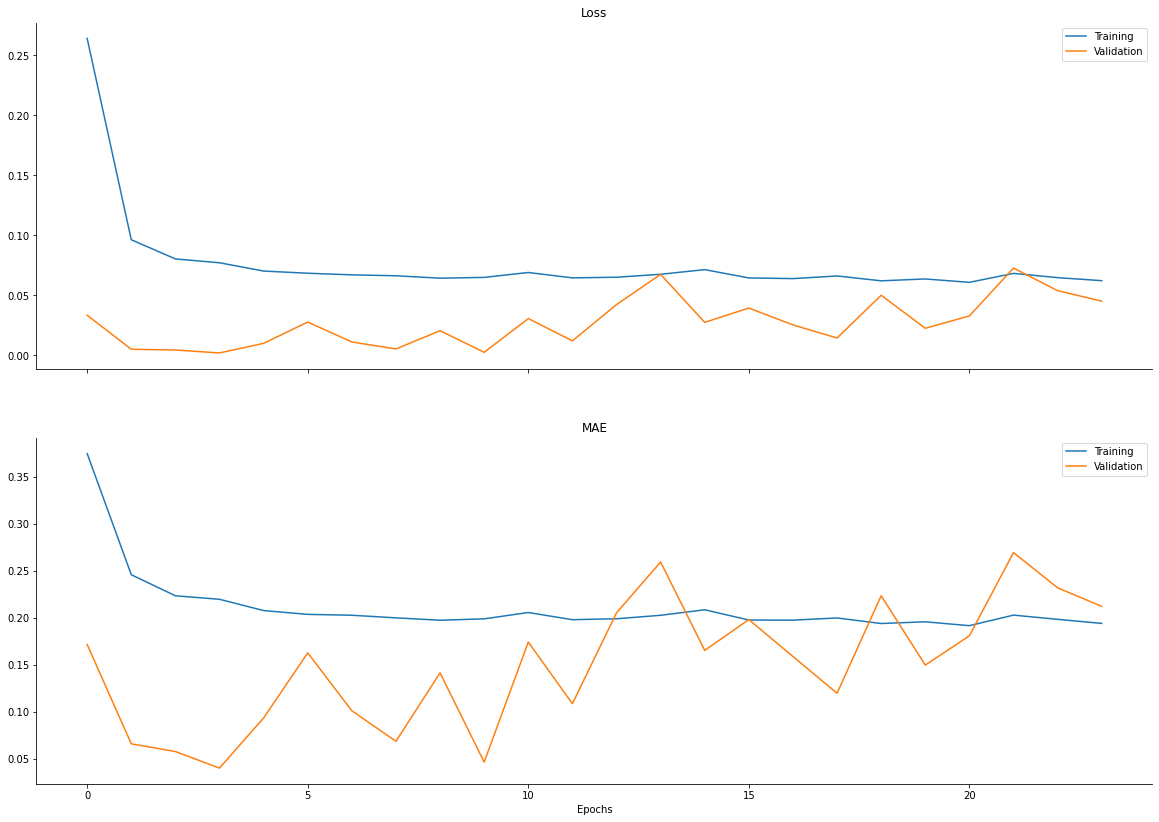

In [59]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['mae'], label='Training')
ax2.plot(history['val_mae'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('MAE')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [60]:
def unscale_series2(s):
  return (s * train_std) +  train_mean

In [61]:
model.load_weights('model.h5')
(mse, mae) = model.evaluate(test_ds)
print('mean squared error = ' + str(mse))
print('mean absolute error = ' + str(mae))

results = model.predict(test_ds)

m = tf.keras.metrics.MeanAbsoluteError()
m.update_state(unscale_series2(y_true[window_size:]), unscale_series2(results))
mae = m.result().numpy()

m = tf.keras.metrics.MeanSquaredError()
m.update_state(unscale_series2(y_true[window_size:]), unscale_series2(results))
mse = m.result().numpy()

report.loc[len(report)] = ['LSTM - Events', mae, mse]

12/12 [==============================] - 0s 24ms/step - loss: 0.0697 - mae: 0.2041
mean squared error = 0.06967823952436447
mean absolute error = 0.204110786318779


# Summary

In [62]:
print(report)

           Model       MAE        MSE
0       Baseline  1.530220   4.387362
1            DNN  2.848437  12.249967
2      SimpleRNN  1.582848   4.231172
3            GRU  1.632726   4.400072
4           LSTM  1.609346   4.587472
5  LSTM - Events  1.573068   4.138667


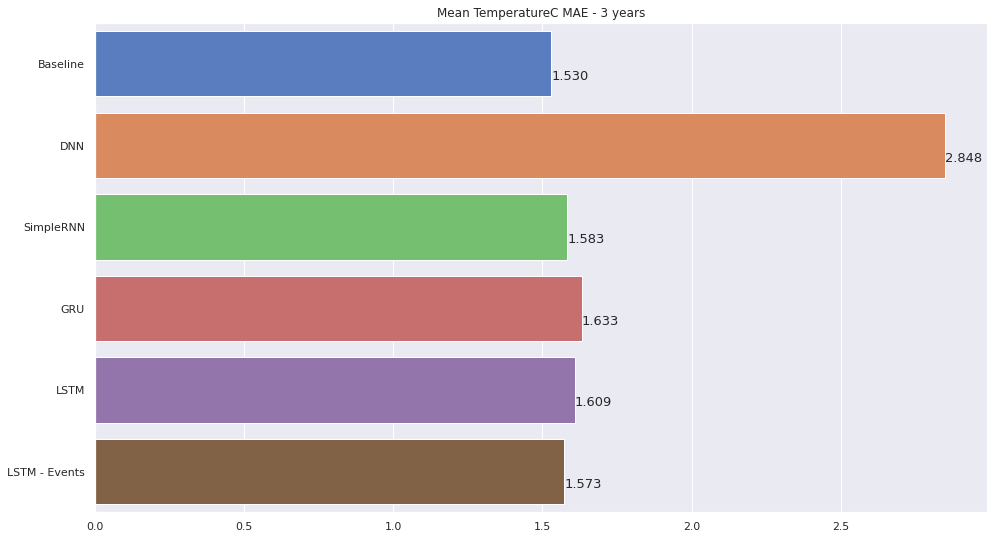

In [63]:
sns.set(rc={'figure.figsize':(16,9)})
ax = sns.barplot(report.MAE, report.Model, orient='h', palette=sns.color_palette("muted"))

for i, mae in enumerate(report.MAE):
    ax.text(mae, i+0.2, f'{mae:.3f}', fontsize=13)
plt.title(f'Mean TemperatureC MAE - 3 years')
plt.xlabel('')
plt.ylabel('')
plt.show()

30 Day Window:

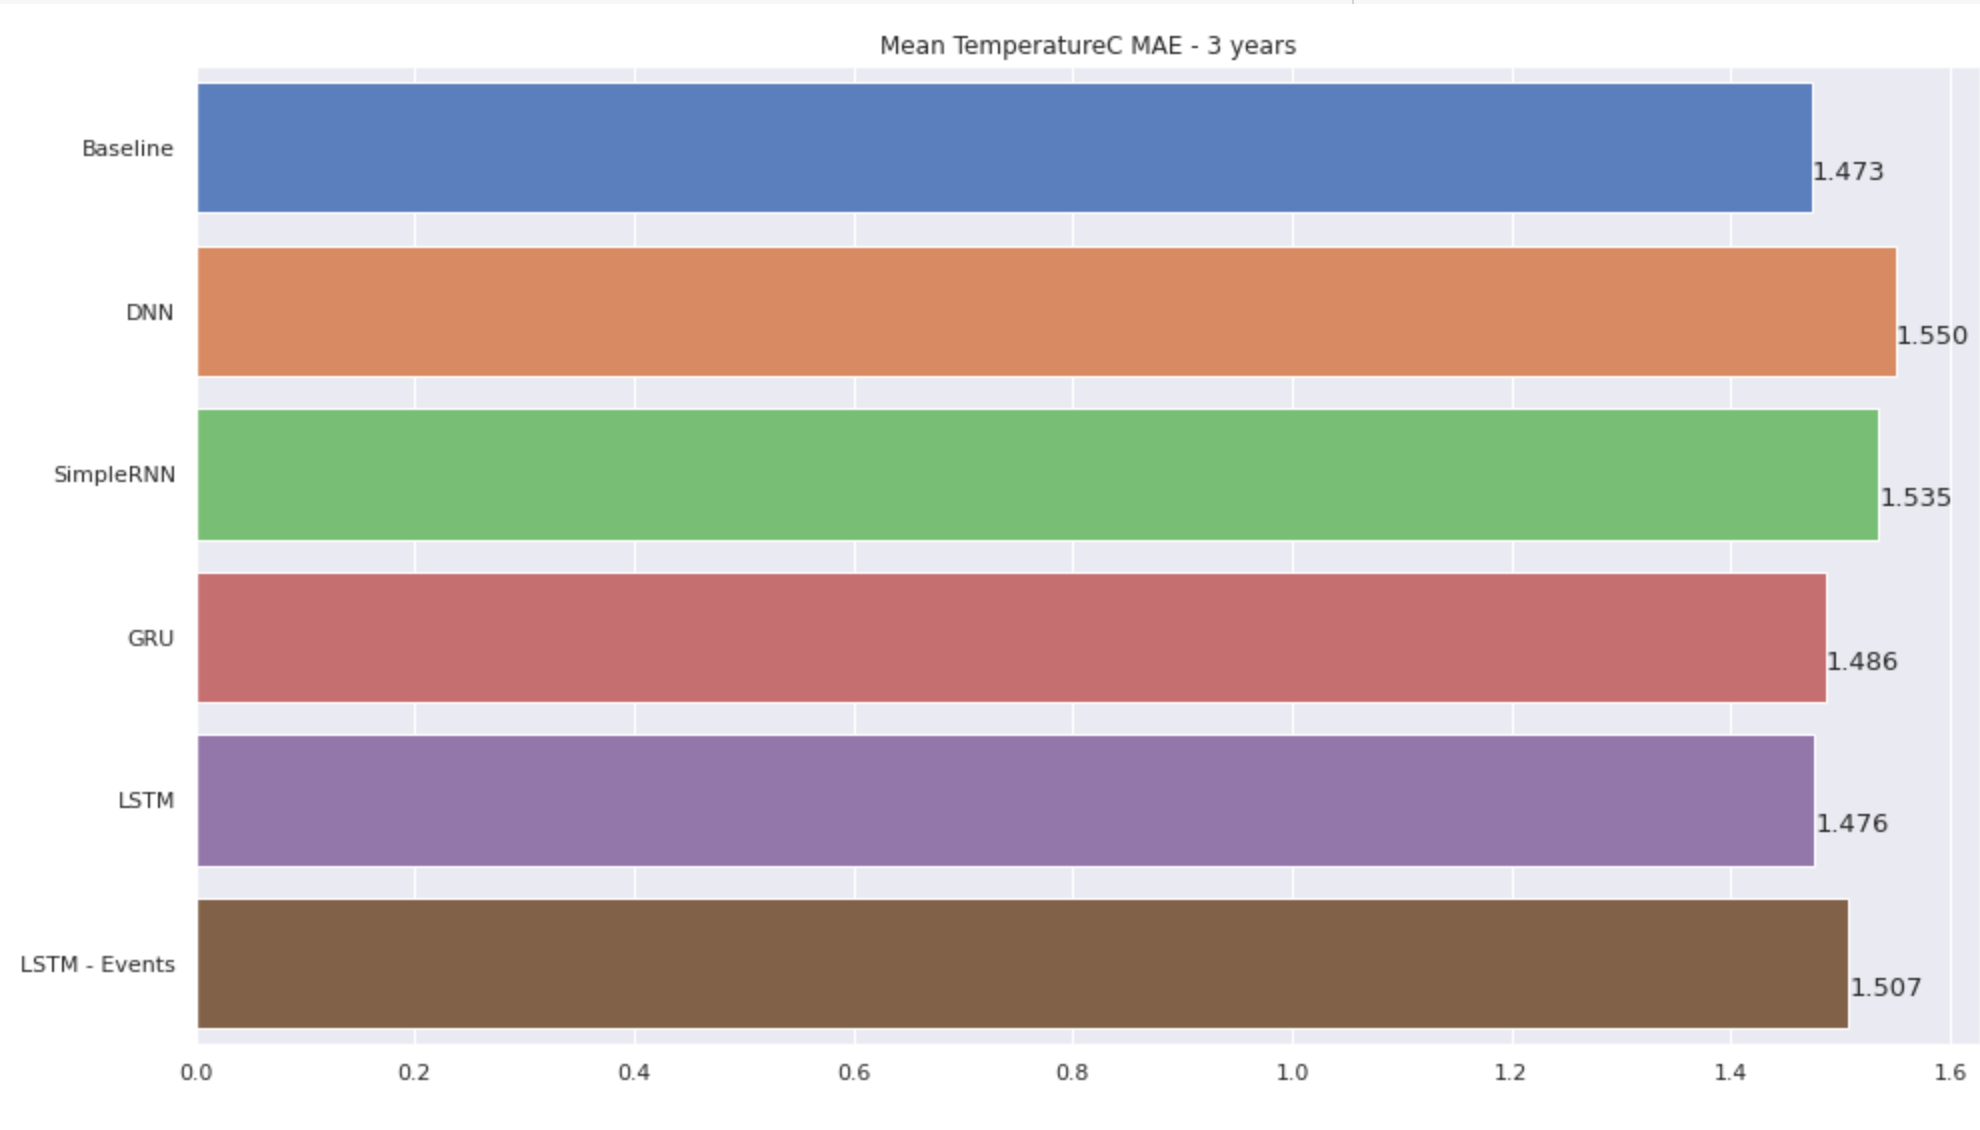

60 Day Window:

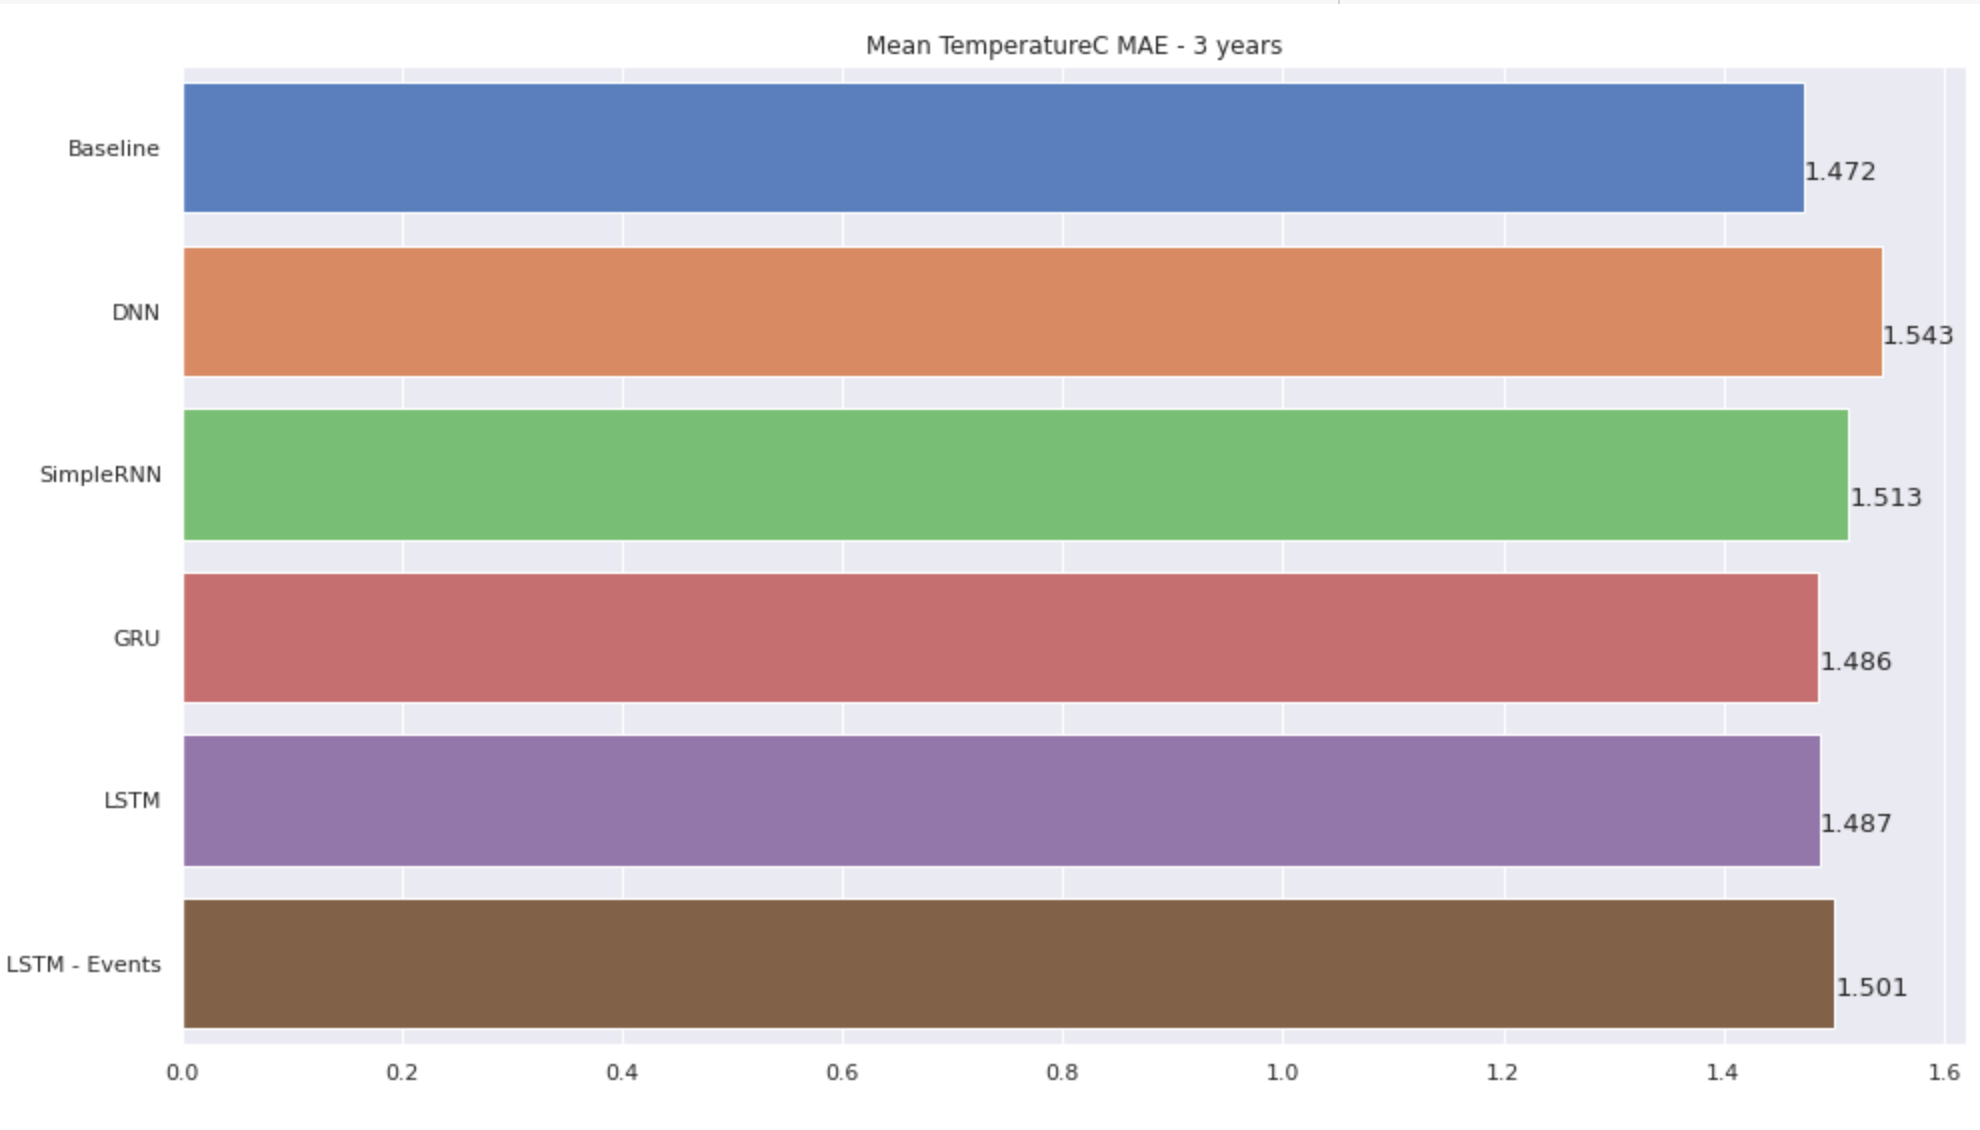

366 Day Window:

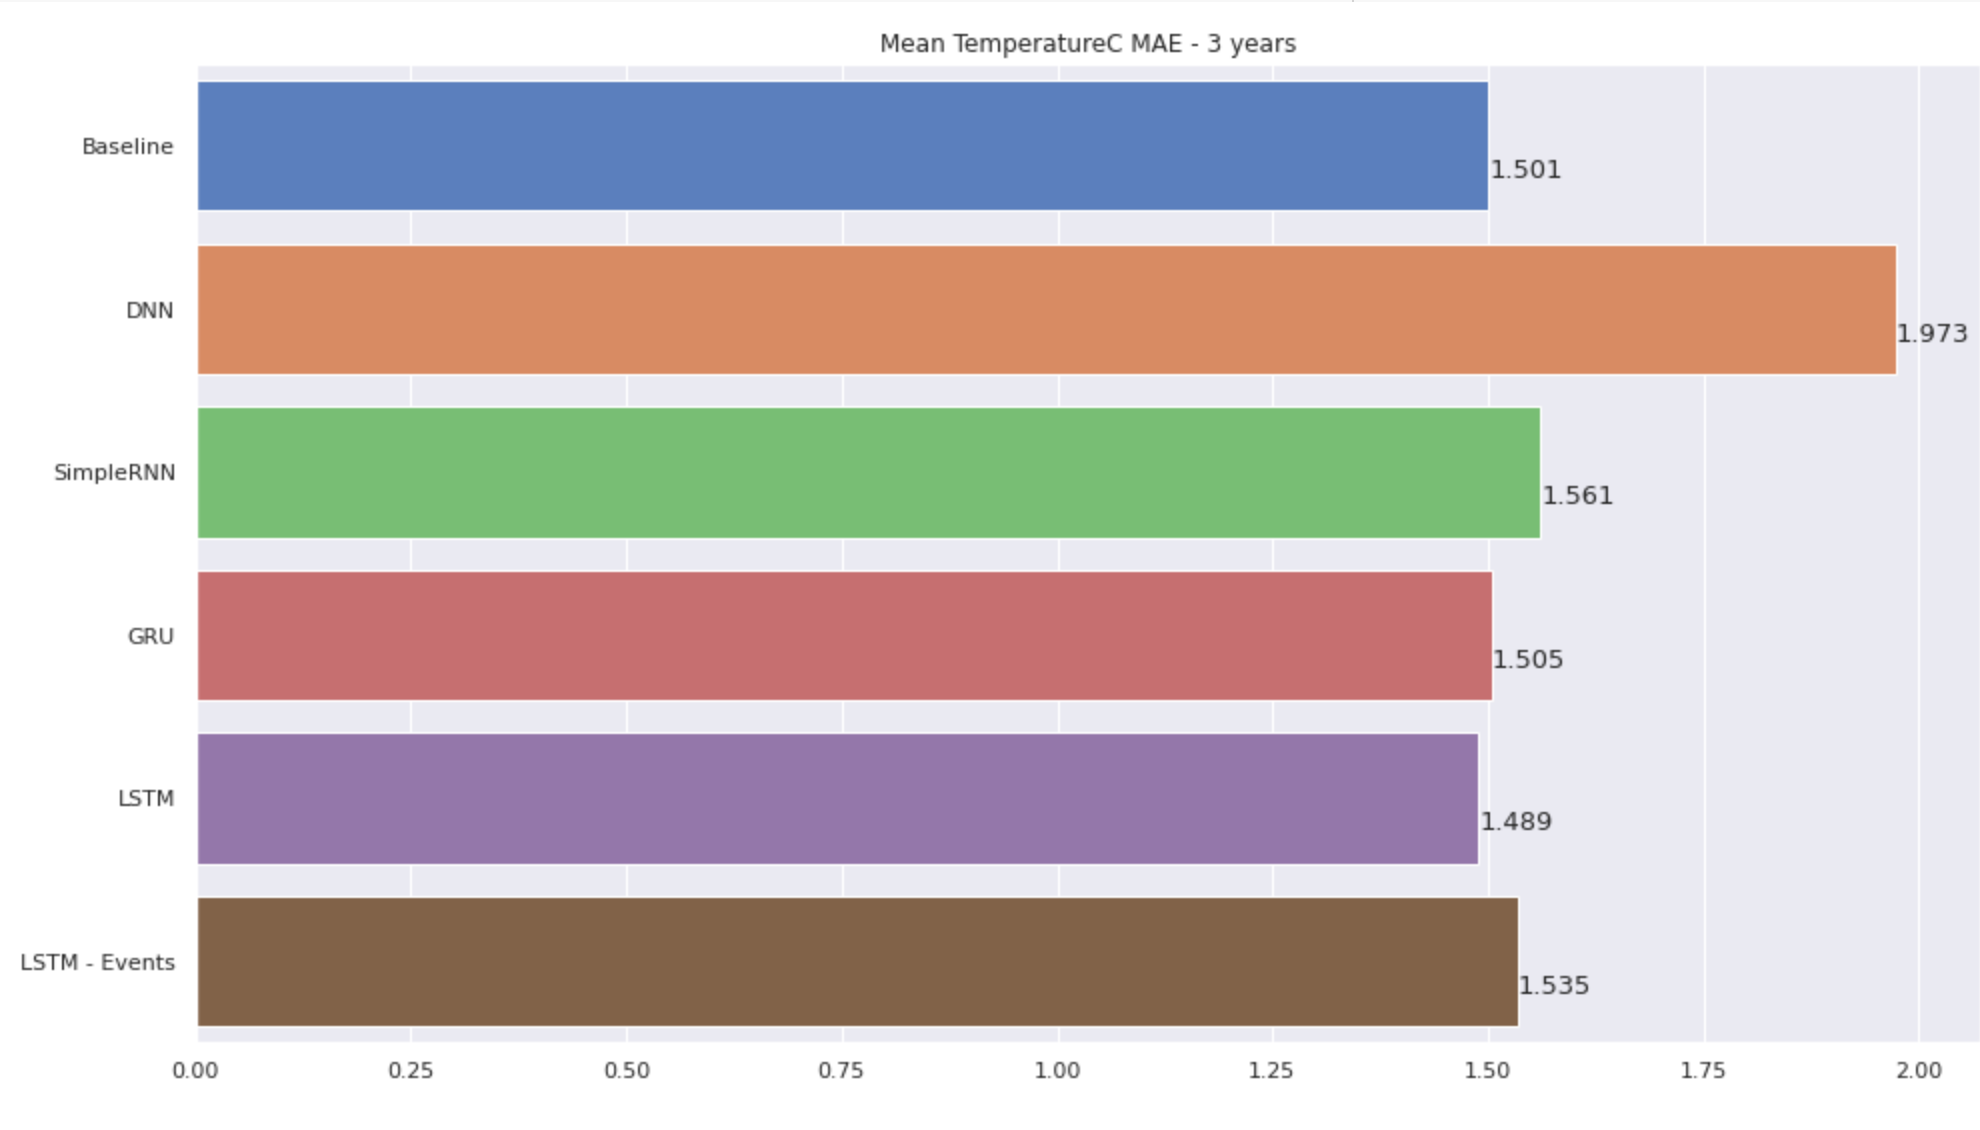

731 Day Window:

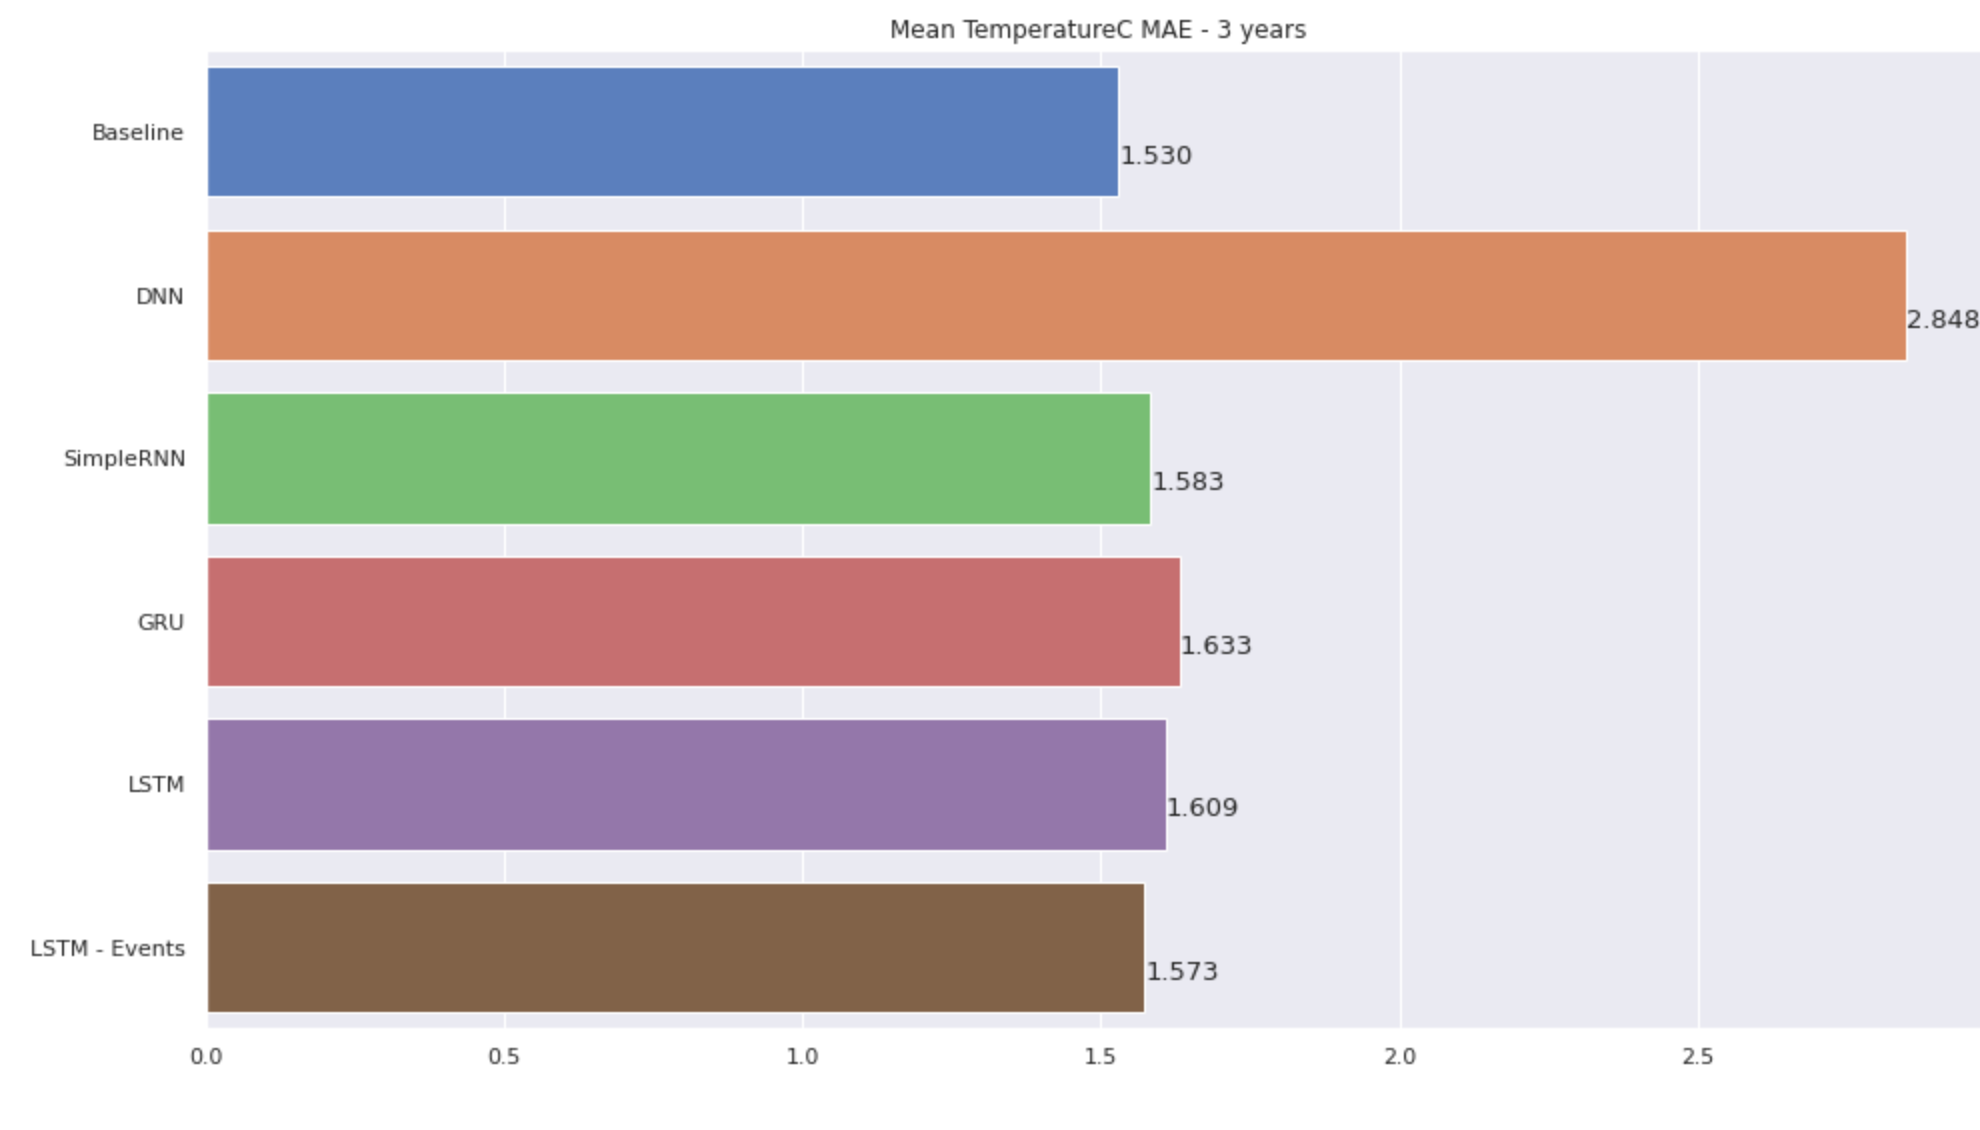


**TODO**: 

1. More features for multivariate model
2. Use regularization on DNN model
3. Create the validation split after creating the windows and shuffling.
4. Try Attention layers
5. Predict Events with multivariate model